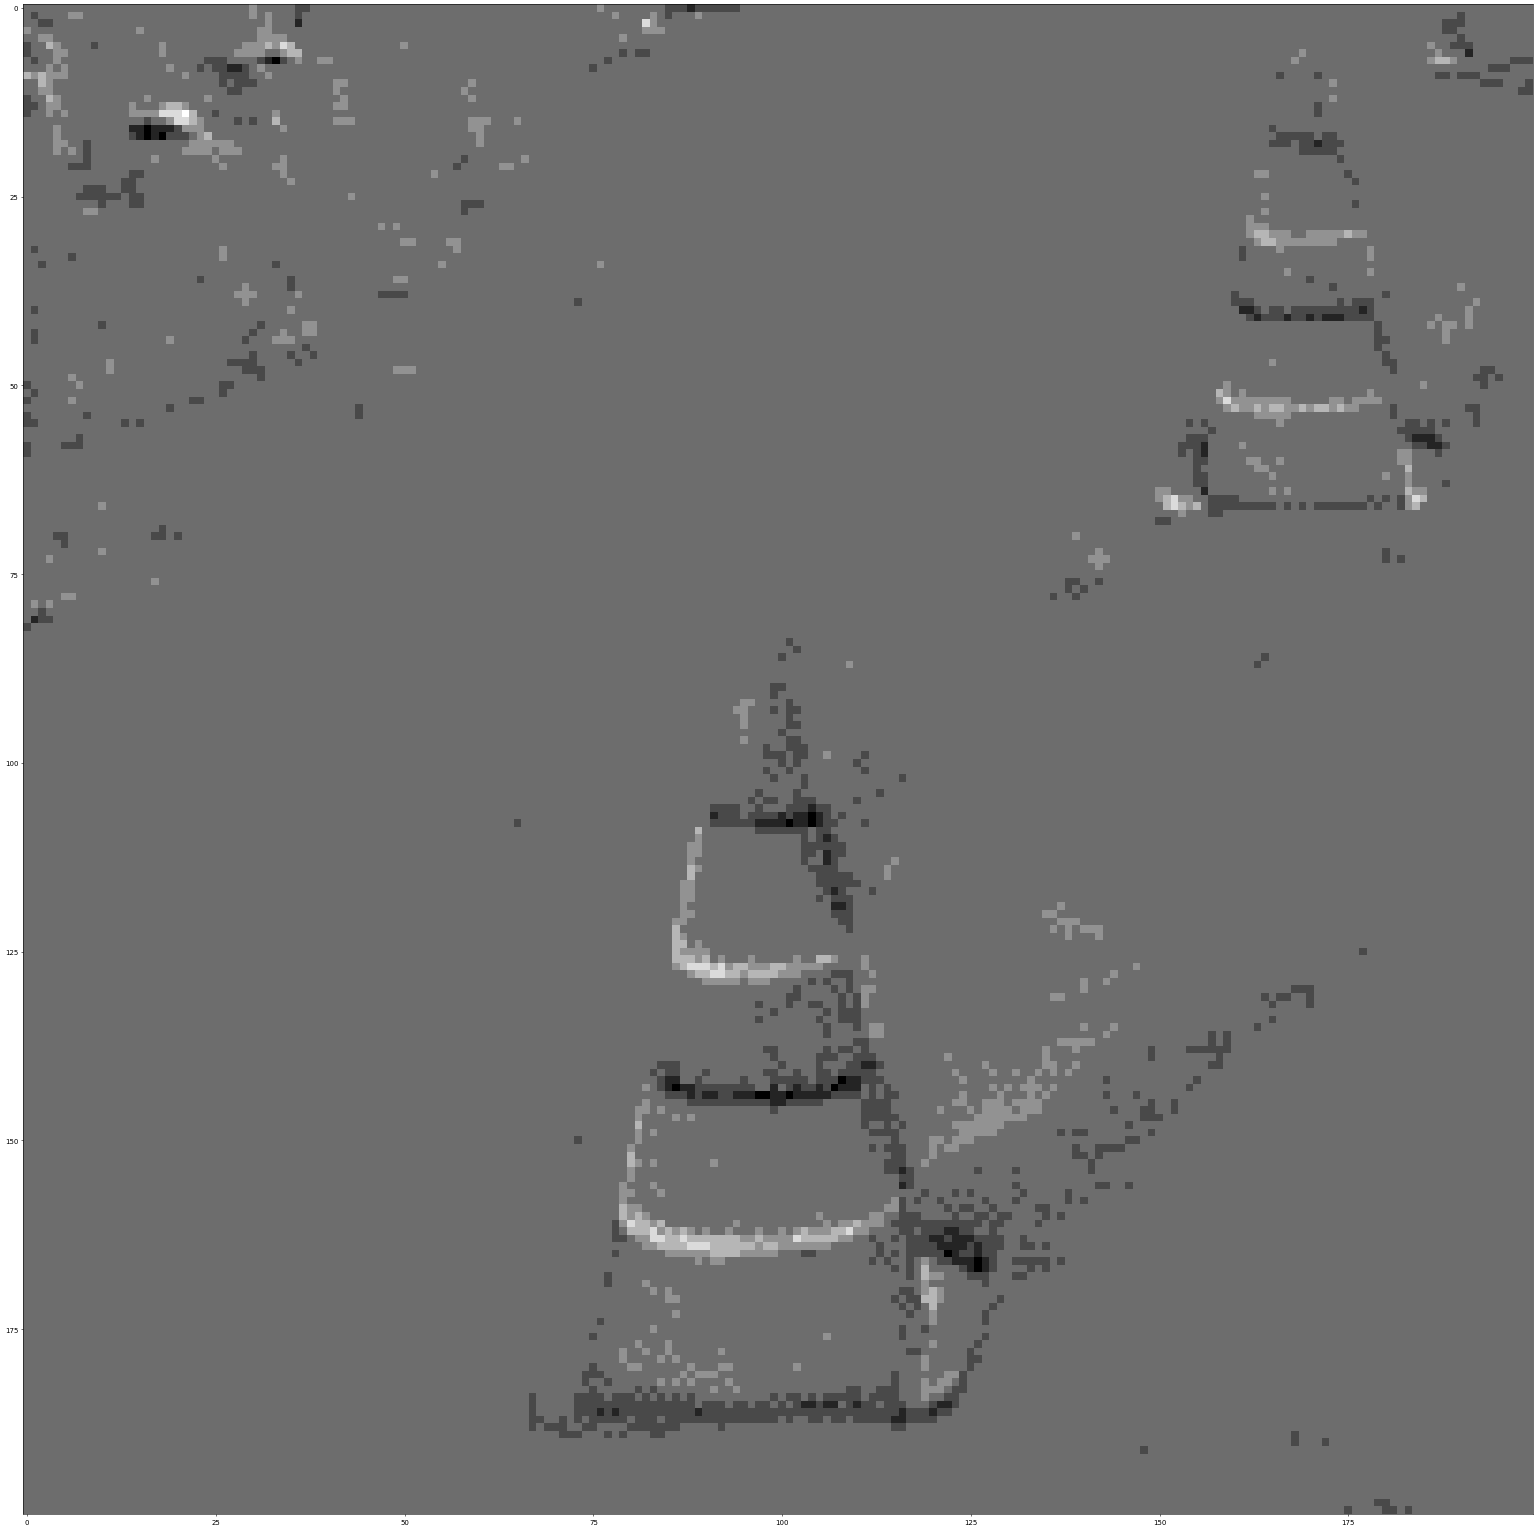

In [1]:
datasetPath = '/home/runqiu/code/event_camera_repo/3rdparty/v2e/output/vibrationRollerNight/sbn/'
## dataset check
import lmdb
import numpy as np
import matplotlib.pyplot as plt
import copy
env = lmdb.open(datasetPath, map_size=1099511627776)
txn = env.begin()
seq = 0
fra = 5
code = '%03d_%08d' % (seq, fra)
code = code.encode()
train_img = txn.get(code)
train_img = np.frombuffer(train_img, dtype='int8')
train_img = train_img.reshape(720, 1280)
plt.figure(figsize=(40, 40), dpi=50)
plt.subplot(1, 1, 1)
plt.imshow(train_img[500:700, 400:600], cmap='gray')

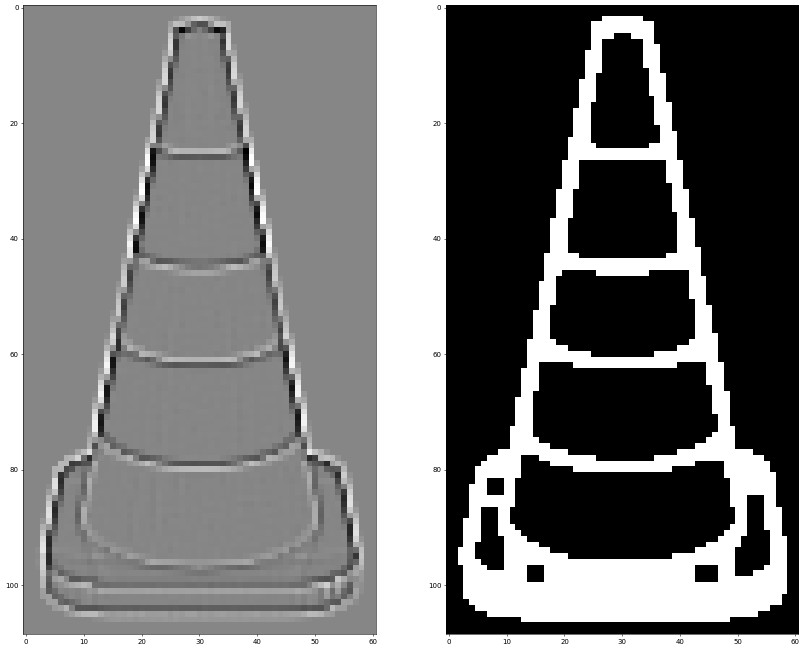

In [2]:
import cv2
import numpy
templatePath = '/home/runqiu/code/event_camera_repo/3rdparty/BlenderProc/VibrationRollerSimulation/output/templates/000028.png'
template = cv2.imread(templatePath, cv2.IMREAD_GRAYSCALE)
template = cv2.resize(template.astype('uint8'), dsize=None, fx=0.33, fy=0.33, interpolation=cv2.INTER_CUBIC)
templateMask = template >= 10
template[~templateMask] = 0
dst = cv2.Laplacian(template, cv2.CV_32F, ksize=3)

plt.figure(figsize=(20, 20), dpi=50)
plt.subplot(121)
plt.imshow(dst, cmap='gray')
plt.subplot(122)
dstMask1 = numpy.where(dst >= 40, 255, 0)
dstMask2 = numpy.where(dst <= -40, 255, 0)
dstMask = dstMask1 + dstMask2
kernels = []
kernels.append(np.ones((3, 3), np.uint8))
dstMask = cv2.morphologyEx(dstMask.astype('uint8'), cv2.MORPH_CLOSE, kernels[0])
plt.imshow(dstMask, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


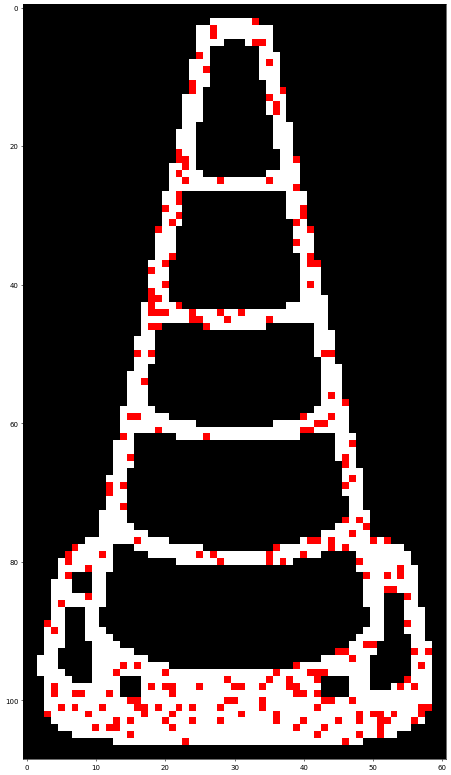

In [3]:
# select n feature points
idx = numpy.where(dstMask > 0)
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(idx[0].shape[0], size=1280, replace=False)

# sampled points
displayImage = numpy.zeros((*dstMask.shape, 3))
displayImage[..., 0] = dstMask
displayImage[..., 1][idx[0][numbers], idx[1][numbers]] = 255
displayImage[..., 2][idx[0][numbers], idx[1][numbers]] = 255

plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(displayImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


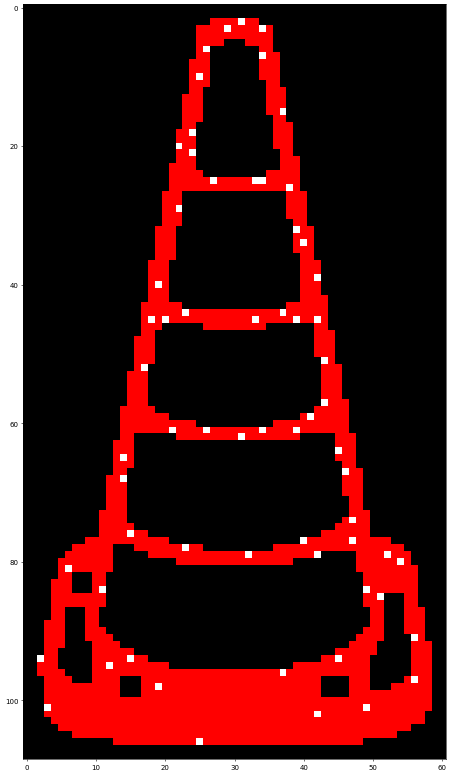

In [4]:
# quad tree
import sys
sys.path.append('/home/runqiu/code/event_camera_repo/3rdparty/BlenderProc/VibrationRollerSimulation/')
from quadtree import Point, Rect, QuadTree

points = [Point(idx[1][index], idx[0][index], 1.0) for index in numbers]
h, w = template.shape
domain = Rect(w // 2, h // 2, w, h)
qtree = QuadTree(domain, 10)
for point in points:
    qtree.insert(point)

import queue
## BFS
def returnDistributedTopScoreNPoints(rootNode, N=600):
    if N > len(rootNode):
        N = len(rootNode)
    nodeQueue = queue.Queue()
    nodeQueue.put(rootNode)
    while nodeQueue.qsize() < N:
#         if nodeQueue.qsize() == 1214:
#             import pdb; pdb.set_trace()
        firstNode = nodeQueue.get()
        if firstNode.divided:
            if len(firstNode.nw) != 0:
                nodeQueue.put(firstNode.nw)
            if len(firstNode.ne) != 0:
                nodeQueue.put(firstNode.ne)
                if nodeQueue.qsize() >= N:
                    break
            if len(firstNode.se) != 0:
                nodeQueue.put(firstNode.se)
                if nodeQueue.qsize() >= N:
                    break
            if len(firstNode.sw) != 0:
                nodeQueue.put(firstNode.sw)
        else:
            if len(firstNode) != 0:
                nodeQueue.put(firstNode)
    return nodeQueue

nodeQueue = returnDistributedTopScoreNPoints(qtree, N=64)
distributedPoints_x, distributedPoints_y = [], []
for i in range(nodeQueue.qsize()):
    thisNode = nodeQueue.get()
    found_points_x, found_points_y, found_points_score = [], [], []
    found_points_x, found_points_y, found_points_score = thisNode.getAllPoints(found_points_x, found_points_y, found_points_score)
    myindex = np.argmax(found_points_score)
#     print(found_points_x[myindex])
    distributedPoints_x.append(found_points_x[myindex])
    distributedPoints_y.append(found_points_y[myindex])
distributedPoints_x, distributedPoints_y = numpy.array(distributedPoints_x), numpy.array(distributedPoints_y)

# distribute points
displayImage = numpy.zeros((*dstMask.shape, 3))
displayImage[..., 0] = dstMask
displayImage[..., 1][distributedPoints_y, distributedPoints_x] = 255
displayImage[..., 2][distributedPoints_y, distributedPoints_x] = 255

plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(displayImage)

In [62]:
def ComputeQuantizedGradientOrientation(imagePatch, numSector=8, gradMagnitudeThreshold=100):
    gray_x = cv2.Sobel(imagePatch, cv2.CV_32F, 1, 0, ksize=3)[1:-1, 1:-1]
    gray_y = cv2.Sobel(imagePatch, cv2.CV_32F, 0, 1, ksize=3)[1:-1, 1:-1]
    grad = gray_y / gray_x
    # print('grad: \n', grad)
    response = numpy.zeros_like(grad, dtype='int')
    for px in range(3):
        for py in range(3):
            if numpy.linalg.norm([gray_x[py, px], gray_y[py, px]]) < gradMagnitudeThreshold:
                response[py, px] = 0
            elif grad[py, px] > 0 and grad[py, px] <= numpy.tan(numpy.pi / numSector):
                response[py, px] = 1
            elif grad[py, px] > numpy.tan(numpy.pi / numSector) and grad[py, px] <= numpy.tan(numpy.pi * 2 / numSector):
                response[py, px] = 2
            elif grad[py, px] > numpy.tan(numpy.pi * 2 / numSector) and grad[py, px] <= numpy.tan(numpy.pi * 3 / numSector):
                response[py, px] = 3
            elif grad[py, px] > numpy.tan(numpy.pi * 3 / numSector):
                response[py, px] = 4
            elif grad[py, px] <= numpy.tan(-numpy.pi * 3 / numSector):
                response[py, px] = 5
            elif grad[py, px] > numpy.tan(-numpy.pi * 3 / numSector) and grad[py, px] <= numpy.tan(-numpy.pi * 2 / numSector):
                response[py, px] = 6
            elif grad[py, px] > numpy.tan(-numpy.pi * 2 / numSector) and grad[py, px] <= numpy.tan(-numpy.pi / numSector):
                response[py, px] = 7
            elif grad[py, px] > numpy.tan(-numpy.pi / numSector) and grad[py, px] <= 0:
                response[py, px] = 8
    # print('response: ', response)
    binCount = numpy.bincount(response.reshape(9,))
    mainScore = numpy.argmax(binCount)
    # print('mainScore: \n', mainScore)
    # if mainScore == 0 and response.sum() > 0:
    #     binCount[mainScore] = 0
    #     print('binCount: \n', binCount)
    #     mainScore = numpy.argmax(binCount)
    return mainScore

class EvlinemodTemplate(object):
    _image = None
    _featureVector = None
    _featurePointsX = None
    _featurePointsY = None
    _imageW = None
    _imageH = None

    def __init__(self, image, featureVector, featurePointsX, featurePointsY):
        self._image = image
        self._imageH = image.shape[0]
        self._imageW = image.shape[1]
        self._featureVector = featureVector
        self._featurePointsX = featurePointsX
        self._featurePointsY = featurePointsY

    @property
    def imageH(self):
        return self._imageH

    @property
    def imageW(self):
        return self._imageW

    @property
    def featureVector(self):
        return self._featureVector

    def ComputeImagePatchFeatureVector(self, imagePatch, gradMagnitudeThreshold=100):
        inputFeatureVector = numpy.zeros_like(self._featureVector)
        for indexPoint, localCenter in enumerate(zip(self._featurePointsY, self._featurePointsX)):
            localPatch = imagePatch[localCenter[0] - 2:localCenter[0] + 3, localCenter[1] - 2:localCenter[1] + 3]
            inputFeatureVector[indexPoint] = ComputeQuantizedGradientOrientation(localPatch, gradMagnitudeThreshold=gradMagnitudeThreshold)
        return inputFeatureVector

featureVector = numpy.zeros_like(distributedPoints_y)
for indexPoint, localCenter in enumerate(zip(distributedPoints_y, distributedPoints_x)):
    localPatch = dst[localCenter[0] - 2:localCenter[0] + 3, localCenter[1] - 2:localCenter[1] + 3]
    featureVector[indexPoint] = ComputeQuantizedGradientOrientation(localPatch)

oneTemplate = EvlinemodTemplate(dst, featureVector, distributedPoints_x, distributedPoints_y)

<ipython-input-62-3e35a9875053>:4: RuntimeWarning: divide by zero encountered in true_divide
  grad = gray_y / gray_x


In [63]:
# detect search
sceneImage = train_img[500:700, 400:600]
uncenteredSceneImage = (sceneImage - sceneImage.min()).astype('float32')

responseMat = numpy.zeros((sceneImage.shape[0] - oneTemplate.imageH, sceneImage.shape[1] - oneTemplate.imageW))
for xx in range(sceneImage.shape[1] - oneTemplate.imageW):
    for yy in range(sceneImage.shape[0] - oneTemplate.imageH):
        scanWindow = uncenteredSceneImage[yy:yy + oneTemplate.imageH, xx:xx + oneTemplate.imageW]
        windowFeatureVector = oneTemplate.ComputeImagePatchFeatureVector(scanWindow, gradMagnitudeThreshold=1)
        pixelResponse = numpy.zeros_like(windowFeatureVector)
        zeroMask = numpy.zeros_like(windowFeatureVector)
        zeroMask[numpy.where(windowFeatureVector == 0)] = 1
        zeroMask = zeroMask.astype('bool')
        pixelResponse[zeroMask] = 8
        pixelResponse[~zeroMask] = numpy.abs(windowFeatureVector[~zeroMask] - oneTemplate.featureVector[~zeroMask])
        responseMat[yy, xx] = pixelResponse.sum()
    print('colum %d finished!', xx)

<ipython-input-62-3e35a9875053>:4: RuntimeWarning: invalid value encountered in true_divide
  grad = gray_y / gray_x
<ipython-input-62-3e35a9875053>:4: RuntimeWarning: divide by zero encountered in true_divide
  grad = gray_y / gray_x


colum %d finished! 0
colum %d finished! 1
colum %d finished! 2
colum %d finished! 3
colum %d finished! 4
colum %d finished! 5
colum %d finished! 6
colum %d finished! 7
colum %d finished! 8
colum %d finished! 9
colum %d finished! 10
colum %d finished! 11
colum %d finished! 12
colum %d finished! 13
colum %d finished! 14
colum %d finished! 15
colum %d finished! 16
colum %d finished! 17
colum %d finished! 18
colum %d finished! 19
colum %d finished! 20
colum %d finished! 21
colum %d finished! 22
colum %d finished! 23
colum %d finished! 24
colum %d finished! 25
colum %d finished! 26
colum %d finished! 27
colum %d finished! 28
colum %d finished! 29
colum %d finished! 30
colum %d finished! 31
colum %d finished! 32
colum %d finished! 33
colum %d finished! 34
colum %d finished! 35
colum %d finished! 36
colum %d finished! 37
colum %d finished! 38
colum %d finished! 39
colum %d finished! 40
colum %d finished! 41
colum %d finished! 42
colum %d finished! 43
colum %d finished! 44
colum %d finished! 4

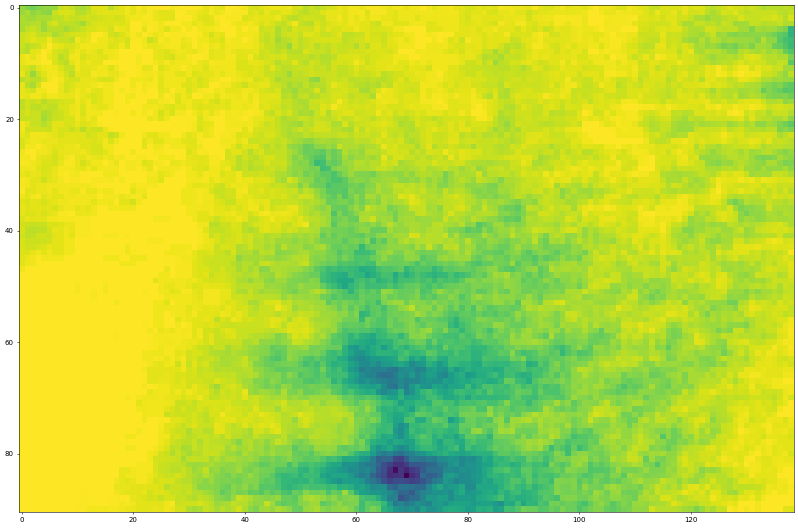

In [65]:
print(numpy.argmax(responseMat))
plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(responseMat/responseMat.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


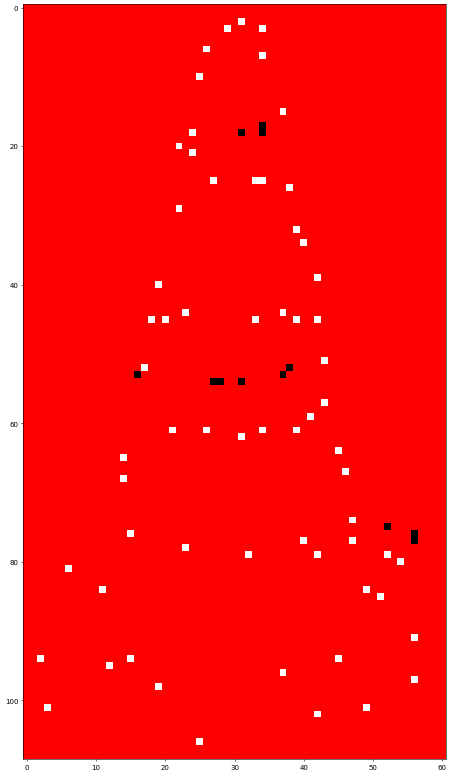